In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
elev_list = pickle_load('Data\\Decomposed_Data_2\\elevation_list.pkl')
elev = pickle_load('Data\\Decomposed_Data_2\\elevation.pkl')

temp_day_list = pickle_load('Data\\Decomposed_Data_2\\temp_day_list.pkl')
temp_day = pickle_load('Data\\Decomposed_Data_2\\temp_day.pkl')

temp_night_list = pickle_load('Data\\Decomposed_Data_2\\temp_night_list.pkl')
temp_night = pickle_load('Data\\Decomposed_Data_2\\temp_night.pkl')

ref_list = pickle_load('Data\\Decomposed_Data_2\\reflectance_list.pkl')
ref = pickle_load('Data\\Decomposed_Data_2\\reflectance.pkl')

good_coords = pickle_load('Data\\Decomposed_Data_2\\good_coords.pkl')

lat = pickle_load('Data\\Decomposed_Data_2\\latitude.pkl')
lon = pickle_load('Data\\Decomposed_Data_2\\longitude.pkl')

In [21]:
indices = np.meshgrid(
    np.arange(len(lat)), np.arange(len(lon)), indexing='ij'
)
order = indices[0][::-1] + indices[1][::-1]
order_present = indices[0] + indices[1][::-1]

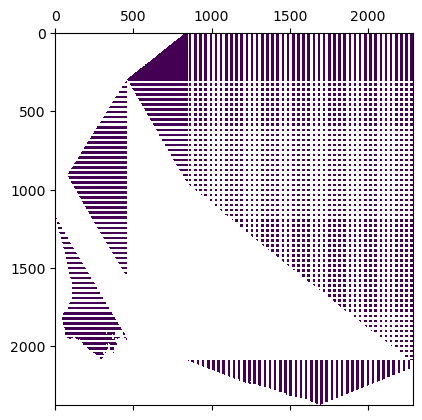

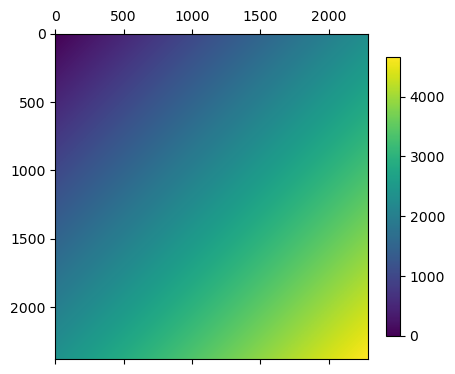

In [22]:
plt.matshow(good_coords[::-1])
plt.matshow(order_present)
plt.colorbar(fraction=0.075, shrink=0.75)

In [37]:
num_good_coords = np.nansum(good_coords)

thresholds = np.percentile(
    np.arange(num_good_coords),
    np.arange(5, 105, 5)
)

splits = np.zeros_like(good_coords) + np.nan
total_found = 0
cur_split = 0
cur_threshold = thresholds[cur_split]

done = False
for rank in np.arange(order.max() + 1, dtype=int):
    if done:
        break
    
    mask = order == rank
    
    lat_indices = indices[0][mask]
    lon_indices = indices[1][mask]
    
    for lat_index, lon_index in zip(lat_indices, lon_indices):
        if not np.isnan(good_coords[lat_index, lon_index]):
            splits[lat_index, lon_index] = cur_split
            total_found += 1
            if total_found >= cur_threshold + 1:
                if cur_split == len(thresholds) - 1:
                    done = True
                    break
                else:
                    cur_split += 1
                    cur_threshold = thresholds[cur_split]

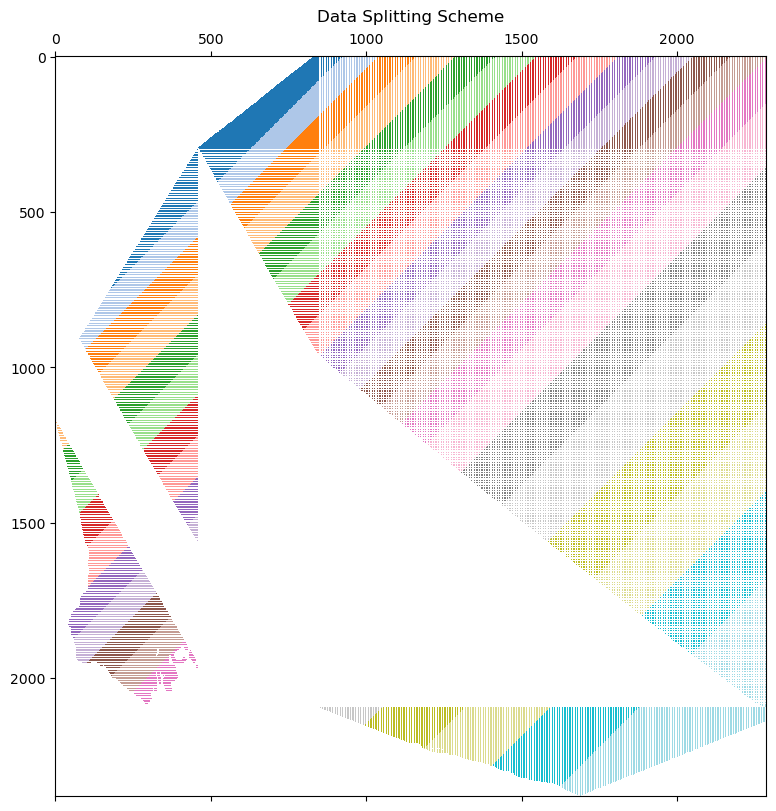

In [41]:
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
ax.matshow(splits[::-1, :], cmap='tab20')
fig.suptitle('Data Splitting Scheme')
plt.show(fig)

In [55]:
save_path = 'Data\\Split_Data_2\\List_Data\\(__)_(**)_list.pkl'

pickle_list = [
    ('elevation', elev),
    ('reflectance', ref),
    ('temp_day', temp_day),
    ('temp_night', temp_night),
]

for split_num in np.arange(np.nanmax(splits) + 1, dtype=int):
    split = splits == split_num
    split_str = f'{"0"*(2-len(str(split_num))) + str(split_num)}'
    save_path_num = save_path.replace('(**)', split_str)
    for name, data in pickle_list:
        save_path_name_num = save_path_num.replace('(__)', name)
        save_data = data[split]
        pickle_save(save_data, save_path_name_num)

In [122]:
save_path = 'Data\\Split_Data_2\\Block_Data\\(__)_(**)_block.pkl'

pickle_list = [
    ('elevation', elev),
    ('reflectance', ref),
    ('temp_day', temp_day),
    ('temp_night', temp_night),
]

for split_num in np.arange(np.nanmax(splits) + 1, dtype=int):
    # split = splits == split_num
    mask = np.array(splits == split_num, dtype=float)
    split_str = f'{"0"*(2-len(str(split_num))) + str(split_num)}'
    save_path_num = save_path.replace('(**)', split_str)
    for name, data in pickle_list:
        save_path_name_num = save_path_num.replace('(__)', name)
        # save_data = data[split]
        if name != 'reflectance':
            save_data = data * mask
        else:
            save_data = data * mask[:, :, np.newaxis].repeat(data.shape[2], 2)
        pickle_save(save_data, save_path_name_num)

KeyboardInterrupt: 